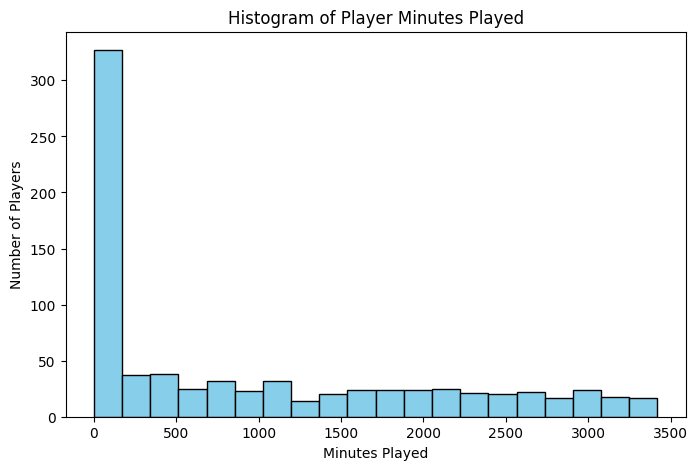

median_minutes: 477.5


[{'id': 2,
  'position': 4,
  'xp': 3.2,
  'total_points': 0,
  'season_points': 42,
  'season_minutes': 600},
 {'id': 2,
  'position': 4,
  'xp': 1.0,
  'total_points': 0,
  'season_points': 42,
  'season_minutes': 600},
 {'id': 2,
  'position': 4,
  'xp': 0.0,
  'total_points': 0,
  'season_points': 42,
  'season_minutes': 600},
 {'id': 2,
  'position': 4,
  'xp': 1.2,
  'total_points': 1,
  'season_points': 42,
  'season_minutes': 600},
 {'id': 2,
  'position': 4,
  'xp': 0.2,
  'total_points': 0,
  'season_points': 42,
  'season_minutes': 600},
 {'id': 2,
  'position': 4,
  'xp': 2.2,
  'total_points': 1,
  'season_points': 42,
  'season_minutes': 600},
 {'id': 2,
  'position': 4,
  'xp': 2.3,
  'total_points': 1,
  'season_points': 42,
  'season_minutes': 600},
 {'id': 2,
  'position': 4,
  'xp': 2.0,
  'total_points': 1,
  'season_points': 42,
  'season_minutes': 600},
 {'id': 2,
  'position': 4,
  'xp': 0.7,
  'total_points': 0,
  'season_points': 42,
  'season_minutes': 600},
 

In [20]:
import numpy as np
import json
import matplotlib.pyplot as plt

# Load player data from JSON file
with open('database/players.json', 'r') as f:
  players = json.load(f)

minutes_played = [player.get('minutes') for player in players if player.get('minutes') is not None]
plt.figure(figsize=(8, 5))
plt.hist(minutes_played, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Minutes Played')
plt.ylabel('Number of Players')
plt.title('Histogram of Player Minutes Played')
plt.show()

median_minutes = np.percentile([player.get('minutes') for player in players], 50)
print('median_minutes:', median_minutes)

# Collect the required information
result = []
for player in players:
  player_id = player.get('id')
  position = player.get('element_type')
  season_minutes = player.get('minutes')
  if (season_minutes < median_minutes):
    continue
  
  season_points = player.get('total_points')
  previous_fixtures = player.get('previous_fixtures', [])
  for fixture in previous_fixtures:
    xp = fixture.get('xp')
    total_points = fixture.get('total_points')
    result.append({
      'id': player_id,
      'position': position,
      'xp': xp,
      'total_points': total_points,
      'season_points': season_points,
      'season_minutes': season_minutes
    })

# result now contains the desired array of dictionaries
result

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
RMSE by position: {1: np.float64(2.3649374419797264), 2: np.float64(2.172878529628463), 3: np.float64(2.366453097406386), 4: np.float64(2.8617148293821804)}


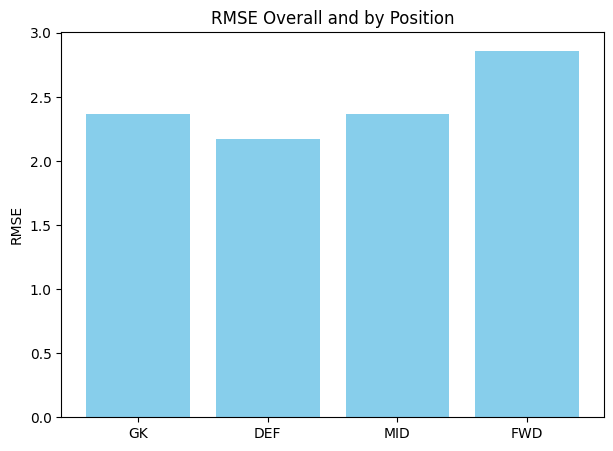

In [21]:
%pip install matplotlib
import matplotlib.pyplot as plt

# Filter out None values from xp and total_points in result
xp_values = [item['xp'] for item in result if item['xp'] is not None and item['total_points'] is not None]
tp_values = [item['total_points'] for item in result if item['xp'] is not None and item['total_points'] is not None]

# Calculate mean square difference
msd = np.mean([(xp - tp) ** 2 for xp, tp in zip(xp_values, tp_values)])
# Calculate root mean squared error

# Calculate RMSE for each position
positions = set(item['position'] for item in result if item['xp'] is not None and item['total_points'] is not None)
position_labels = { 1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
rmse_by_position = {}
for pos in positions:
  xp_pos = [item['xp'] for item in result if item['position'] == pos and item['xp'] is not None and item['total_points'] is not None]
  tp_pos = [item['total_points'] for item in result if item['position'] == pos and item['xp'] is not None and item['total_points'] is not None]
  if xp_pos and tp_pos:
    msd_pos = np.mean([(xp - tp) ** 2 for xp, tp in zip(xp_pos, tp_pos)])
    rmse_by_position[pos] = np.sqrt(msd_pos)
  else:
    rmse_by_position[pos] = None

print("RMSE by position:", rmse_by_position)
rmse = np.sqrt(msd)
# Plot a bar chart for overall RMSE and RMSE by position
labels = [position_labels[pos] for pos in sorted(rmse_by_position.keys())]
values = [rmse_by_position[pos] for pos in sorted(rmse_by_position.keys())]

plt.figure(figsize=(7, 5))
plt.bar(labels, values, color='skyblue')
plt.ylabel('RMSE')
plt.title('RMSE Overall and by Position')
plt.show()

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


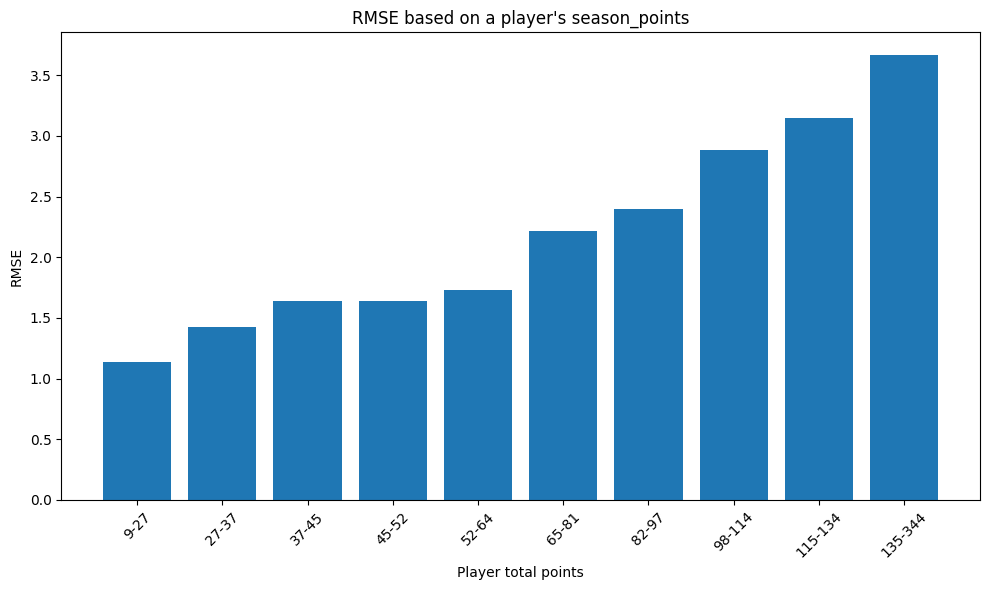

In [22]:
%pip install matplotlib
from collections import defaultdict

# Calculate season_points per player from the player data
player_season_points = {player['id']: player.get('season_points', 0) for player in result}
num_bins = 10  # Update to 10 bins

# Re-bin players into equal-sized buckets based on their season_points
sorted_players = sorted(player_season_points.items(), key=lambda x: x[1])
bin_size = len(sorted_players) // num_bins
bins = []
bin_ranges = []
for i in range(num_bins):
  start = i * bin_size
  end = (i + 1) * bin_size if i < num_bins - 1 else len(sorted_players)
  bin_players = [pid for pid, _ in sorted_players[start:end]]
  bins.append(bin_players)
  if bin_players:
    min_points = player_season_points[bin_players[0]]
    max_points = player_season_points[bin_players[-1]]
  else:
    min_points = max_points = None
  bin_ranges.append((min_points, max_points))

# For each bin, collect xp and total_points for all fixtures of players in the bin
bin_rmse = []
for b in bins:
  xp_bin = []
  tp_bin = []
  for item in result:
    if item['id'] in b and item['xp'] is not None and item['total_points'] is not None:
      xp_bin.append(item['xp'])
      tp_bin.append(item['total_points'])
  if xp_bin and tp_bin:
    msd_bin = np.mean([(xp - tp) ** 2 for xp, tp in zip(xp_bin, tp_bin)])
    rmse_bin = np.sqrt(msd_bin)
  else:
    rmse_bin = None
  bin_rmse.append(rmse_bin)

# Prepare labels for bins
bin_labels = [f"{r[0]}-{r[1]}" if r[0] is not None else "N/A" for r in bin_ranges]

plt.figure(figsize=(10, 6))
plt.bar(bin_labels, bin_rmse)
plt.xlabel('Player total points')
plt.ylabel('RMSE')
plt.title('RMSE based on a player\'s season_points')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


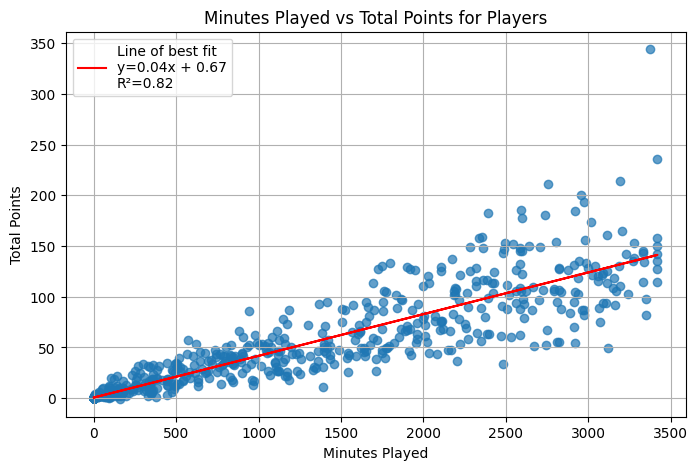

In [23]:
%pip install scipy
from scipy import stats

# Prepare data for scatter plot: X = minutes, Y = total_points
minutes = [player['minutes'] for player in players]
points = [player['total_points'] for player in players]

slope, intercept, r_value, p_value, std_err = stats.linregress(minutes, points)
# The R-score (Pearson correlation coefficient)
r_squared = r_value**2
# Create the line of best fit using the calculated slope and intercept
line_of_best_fit = slope * np.array(minutes) + intercept

plt.figure(figsize=(8, 5))
plt.scatter(minutes, points, alpha=0.7)
plt.plot(minutes, line_of_best_fit, color='red', label=f'Line of best fit\ny={slope:.2f}x + {intercept:.2f}\nR²={r_squared:.2f}')
plt.xlabel('Minutes Played')
plt.ylabel('Total Points')
plt.title('Minutes Played vs Total Points for Players')
plt.grid(True)
plt.legend()
plt.show()

Gameweek 1: RMSE = 1.563
Gameweek 2: RMSE = 1.751
Gameweek 3: RMSE = 1.707
Gameweek 4: RMSE = 2.165
Gameweek 5: RMSE = 1.969
Gameweek 6: RMSE = 2.320
Gameweek 7: RMSE = 2.347
Gameweek 8: RMSE = 2.660
Gameweek 9: RMSE = 2.381
Gameweek 10: RMSE = 2.454
Gameweek 11: RMSE = 2.411
Gameweek 12: RMSE = 2.703
Gameweek 13: RMSE = 3.122
Gameweek 14: RMSE = 2.924
Gameweek 15: RMSE = 3.169
Gameweek 16: RMSE = 3.346
Gameweek 17: RMSE = 4.029
Gameweek 18: RMSE = 3.317
Gameweek 19: RMSE = 3.782
Gameweek 20: RMSE = 3.540
Gameweek 21: RMSE = 3.218
Gameweek 22: RMSE = 5.809
Gameweek 23: RMSE = 4.683
Gameweek 24: RMSE = 3.351
Gameweek 25: RMSE = 3.060
Gameweek 26: RMSE = 3.925
Gameweek 27: RMSE = 3.872
Gameweek 28: RMSE = 3.196
Gameweek 29: RMSE = 3.637
Gameweek 30: RMSE = 2.840
Gameweek 31: RMSE = 3.451
Gameweek 32: RMSE = 7.212
Gameweek 33: RMSE = 4.272
Gameweek 34: RMSE = 8.431
Gameweek 35: RMSE = 4.058
Gameweek 36: RMSE = 4.050


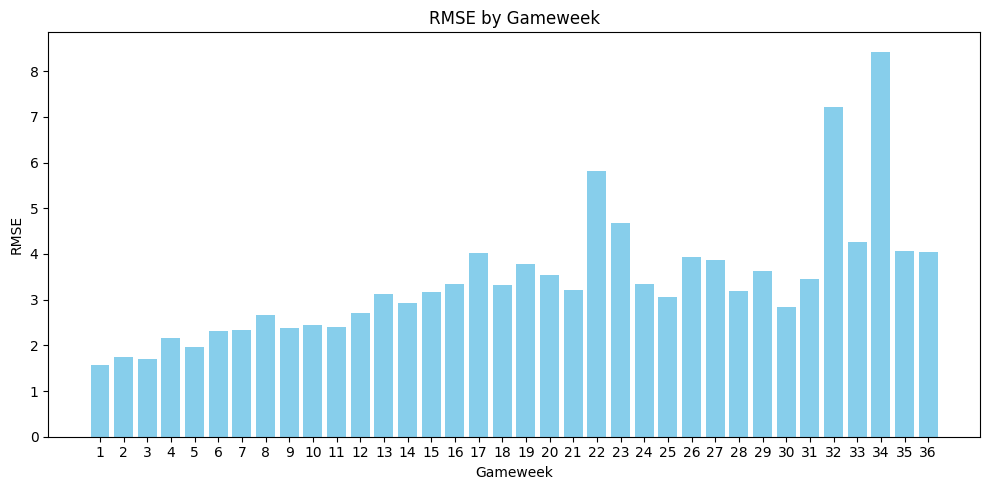

In [24]:
from collections import defaultdict

# Calculate RMSE by gameweek (fixture round)

# Group xp and total_points by gameweek (round)
gw_xp = defaultdict(list)
gw_tp = defaultdict(list)

for item in result:
  xp = item.get('xp')
  tp = item.get('total_points')
  # Find the fixture round for this entry
  # We need to find the round from the player's previous_fixtures
  # Find the player in players list
  player_id = item['id']
  player = next((p for p in players if p['id'] == player_id), None)
  if player and 'previous_fixtures' in player:
    # Find the fixture that matches xp and total_points
    for fixture in player['previous_fixtures']:
      if fixture.get('total_points') == tp:
        round_num = fixture.get('round')
        if xp is not None and tp is not None and round_num is not None:
          gw_xp[round_num].append(xp)
          gw_tp[round_num].append(tp)
        break

# Compute RMSE for each gameweek
gw_rmse = {}
for gw in sorted(gw_xp.keys()):
  xp_list = gw_xp[gw]
  tp_list = gw_tp[gw]
  if xp_list and tp_list:
    msd = np.mean([(xp - tp) ** 2 for xp, tp in zip(xp_list, tp_list)])
    gw_rmse[gw] = np.sqrt(msd)
  else:
    gw_rmse[gw] = None

# Print or display the RMSE by gameweek
for gw, rmse in sorted(gw_rmse.items()):
  print(f"Gameweek {gw}: RMSE = {rmse:.3f}" if rmse is not None else f"Gameweek {gw}: No data")

# Plot RMSE by gameweek as a bar chart
plt.figure(figsize=(10, 5))
plt.bar(list(gw_rmse.keys()), [gw_rmse[gw] for gw in gw_rmse], color='skyblue')
plt.xlabel('Gameweek')
plt.ylabel('RMSE')
plt.title('RMSE by Gameweek')
plt.xticks(list(gw_rmse.keys()))
plt.tight_layout()
plt.show()

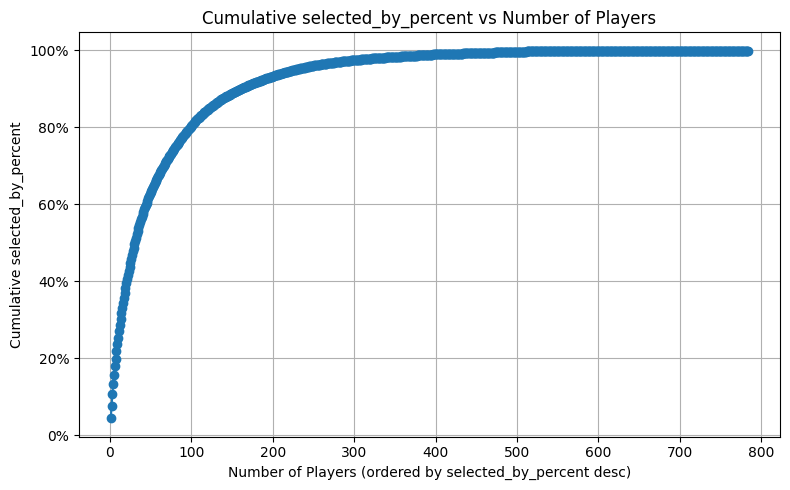

Total selected_by_percent: 1497.3999999999985


In [25]:
# Sum up the selected_by_percent for each player and log out the total
total_selected_by_percent = sum(float(player.get('selected_by_percent', 0)) for player in players)
# Sort players by selected_by_percent descending
sorted_players_by_selected = sorted(players, key=lambda p: float(p.get('selected_by_percent', 0)), reverse=True)
selected_by_percent_values = [float(p.get('selected_by_percent', 0)) for p in sorted_players_by_selected]

# Compute cumulative sum
cumulative_selected = np.cumsum(selected_by_percent_values)

# Plot line graph
plt.figure(figsize=(8, 5))
# Divide by 1500 because 15 * 100% is the total selection amount
plt.plot(range(1, len(cumulative_selected) + 1), cumulative_selected / 1500, marker='o', linestyle='-')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlabel('Number of Players (ordered by selected_by_percent desc)')
plt.ylabel('Cumulative selected_by_percent')
plt.title('Cumulative selected_by_percent vs Number of Players')
plt.grid(True)
plt.tight_layout()
plt.show()